In [2]:
# torchfactor package
from torchfactor.factorization.nmfnet import NMFNet
from torchfactor.experiment.experiment import Experiment

# other imports
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [8]:
class StackedMNISTDataset(torch.utils.data.Dataset):
    """A 1 element dataset that returns a column-wise stack of flattened images
    for NMF training.
    """
    
    def __init__(self, stacksize):
        self.mnist = torchvision.datasets.MNIST(
            "../../data/mnist", train=True,
            transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        )
        self.stacksize = stacksize
        self.img_indices = np.random.randint(0, len(self.mnist), size=self.stacksize)
        self.img_stack = torch.zeros((28*28, self.stacksize))
        
        for i in range(self.img_indices.shape[0]):
            self.img_stack[:,i] = self.mnist[self.img_indices[i]][0].flatten()
                
    def __len__(self):
        return 1
    
    def __getitem__(self, index):
        return self.img_stack
    
    
def show_recons(input_X, W, H):
    stackrecons = W @ H

    fig, ax = plt.subplots(10, 2, figsize=(10, 20))
    for i in range(len(ax)):
        img_recons = stackrecons[:,i].reshape((28,28))

        ax[i, 0].imshow(input_X[:,i].reshape((28,28)))
        ax[i, 0].set_title('Original Matrix {}'.format(i))

        recon_loss = torch.nn.functional.mse_loss(torch.Tensor(stackrecons[:,i]), 
                                                  torch.Tensor(input_X[:,i]))
        ax[i, 1].imshow(img_recons)
        ax[i, 1].set_title('W @ H Matrix -- Recon Error:{:2f}'.format(recon_loss))

    plt.tight_layout()
    plt.show()
    
    
def show_cols(W):
    fig, ax = plt.subplots(5, 2, figsize=(10, 20))
    for i in range(len(ax)):
        ax[i, 0].imshow(W[:,2 * i].reshape((28,28)))
        ax[i, 1].imshow(W[:,2 * i + 1].reshape((28, 28)))

    plt.tight_layout()
    plt.suptitle('Columns of W', fontsize=20, y=1.02)
    plt.show()

In [9]:
imstack_dataset = StackedMNISTDataset(stacksize=200)
imstack_dataloader = torch.utils.data.DataLoader(
    imstack_dataset, batch_size=1
)

epoch 0: total loss is 0.10190560668706894, avg loss is 0.10190560668706894
epoch 0: val avg loss is 0.09874814003705978
epoch 1000: total loss is 0.03132516145706177, avg loss is 0.03132516145706177
epoch 1000: val avg loss is 0.031323838979005814
epoch 2000: total loss is 0.030583657324314117, avg loss is 0.030583657324314117
epoch 2000: val avg loss is 0.030583374202251434
epoch 3000: total loss is 0.03027774766087532, avg loss is 0.03027774766087532
epoch 3000: val avg loss is 0.030277632176876068
epoch 4000: total loss is 0.030170148238539696, avg loss is 0.030170148238539696
epoch 4000: val avg loss is 0.030170047655701637


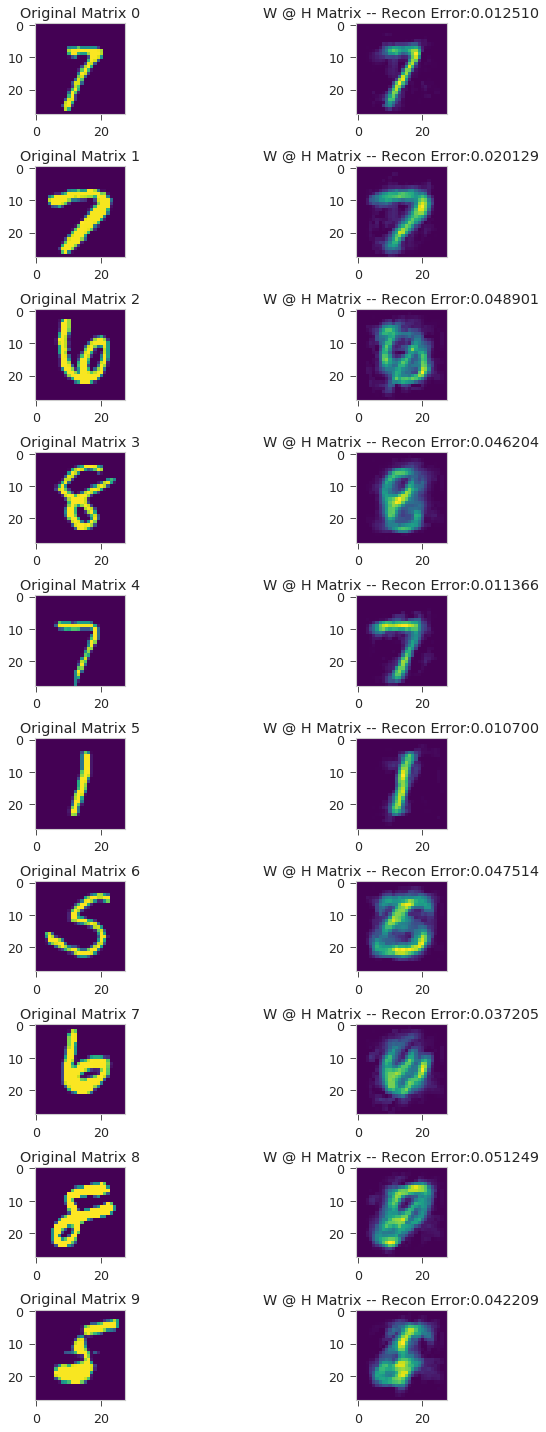

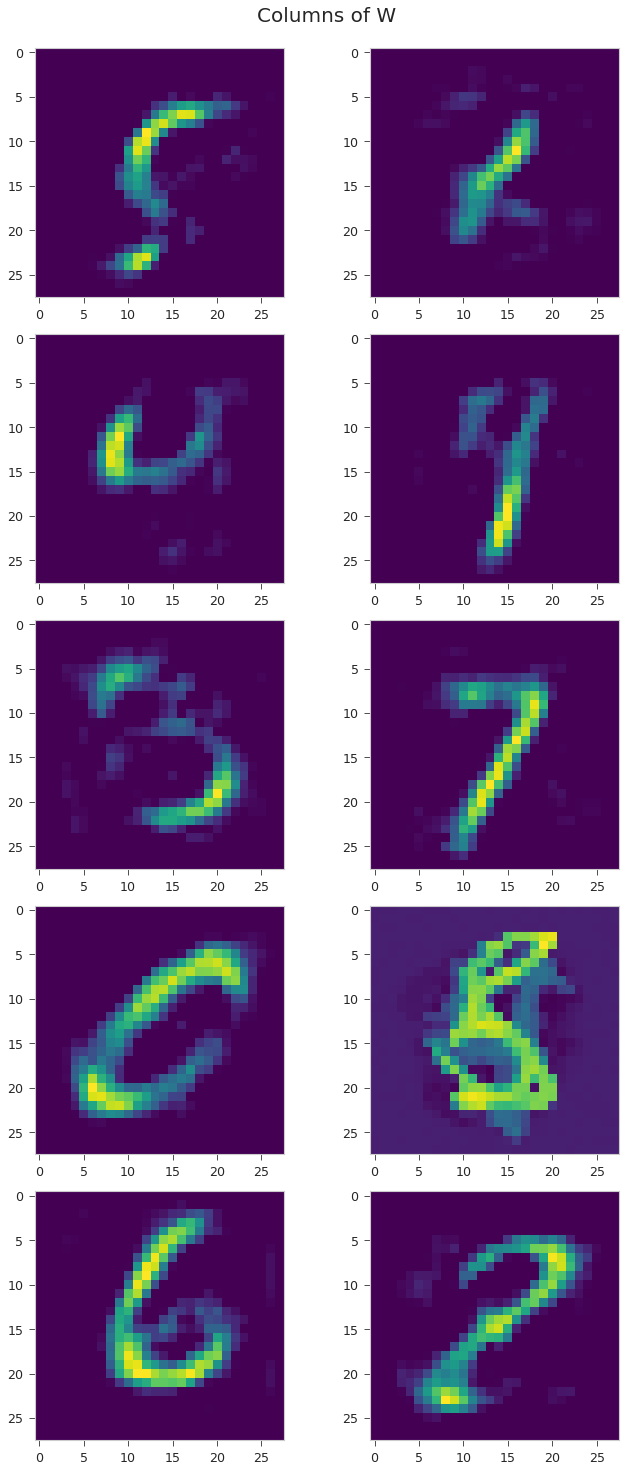

In [10]:
### NMFNet with L2 Loss

num_comp = 20
net = NMFNet(28*28, num_comp)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

experiment = Experiment(
    net=net, loss=torch.nn.MSELoss(), optimizer=optimizer,
    train_dataloader=imstack_dataloader, validation_dataloader=imstack_dataloader,
    inputs_are_ground_truth=True, has_labels=False
)

train_loss_over_epochs, val_loss_over_epochs, _ = experiment.run(
    train_epochs=5000, train_validation_interval=1000
)

input_X = imstack_dataset[0]
W_net = net.get_W().detach().numpy()
H_net = net.get_H(input_X).detach().numpy()

show_recons(input_X, W_net, H_net)
show_cols(W_net)

epoch 0: total loss is 0.05093364417552948, avg loss is 0.05093364417552948
epoch 0: val avg loss is 0.04941215366125107
epoch 1000: total loss is 0.015385881997644901, avg loss is 0.015385881997644901
epoch 1000: val avg loss is 0.015385040082037449
epoch 2000: total loss is 0.014873120002448559, avg loss is 0.014873120002448559
epoch 2000: val avg loss is 0.014873011037707329
epoch 3000: total loss is 0.014759673736989498, avg loss is 0.014759673736989498
epoch 3000: val avg loss is 0.014759606681764126
epoch 4000: total loss is 0.014697238802909851, avg loss is 0.014697238802909851
epoch 4000: val avg loss is 0.014697220176458359


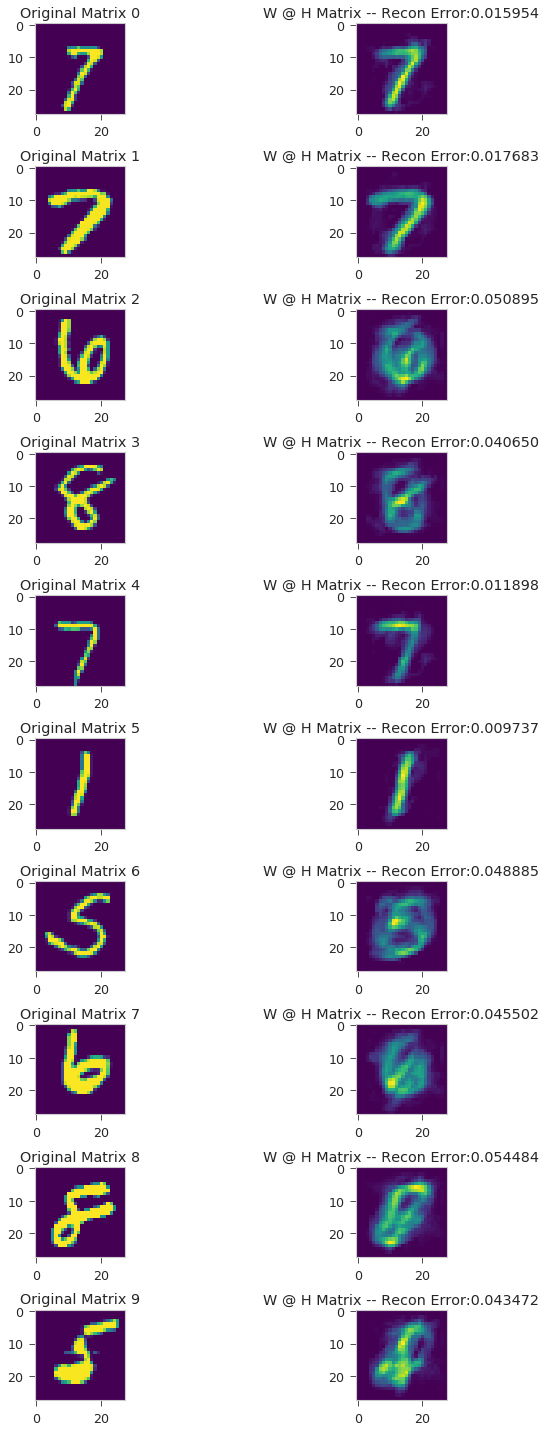

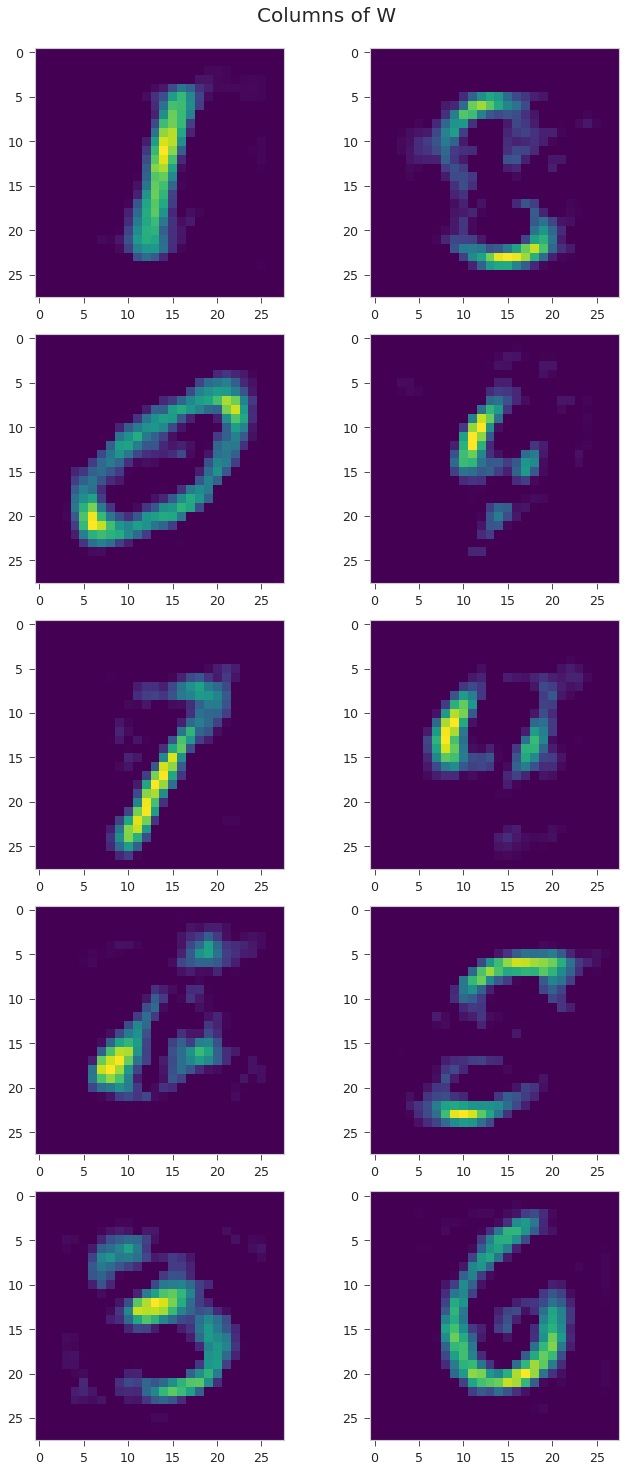

In [26]:
### NMFNet with Hyrbid Loss
num_comp = 20
net = NMFNet(28*28, num_comp)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

experiment = Experiment(
    net=net, loss=torch.nn.SmoothL1Loss(), optimizer=optimizer,
    train_dataloader=imstack_dataloader, validation_dataloader=imstack_dataloader,
    inputs_are_ground_truth=True, has_labels=False
)

train_loss_over_epochs, val_loss_over_epochs, _ = experiment.run(
    train_epochs=5000, train_validation_interval=1000
)

input_X = imstack_dataset[0]
W_net = net.get_W().detach().numpy()
H_net = net.get_H(input_X).detach().numpy()

show_recons(input_X, W_net, H_net)
show_cols(W_net)

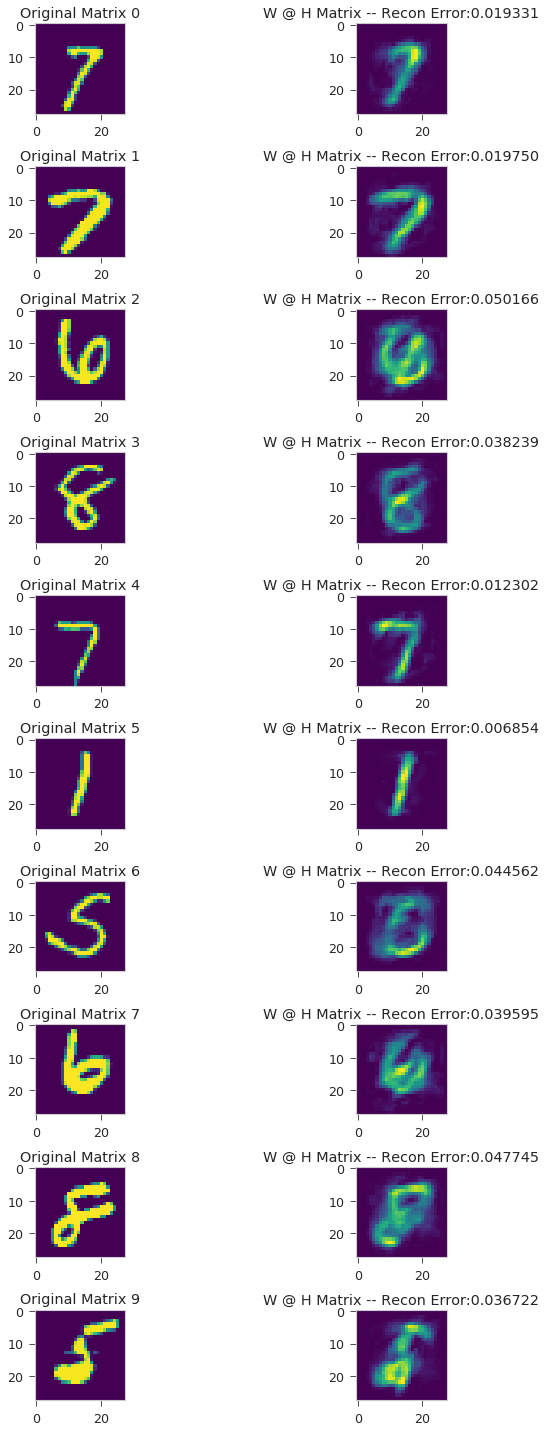

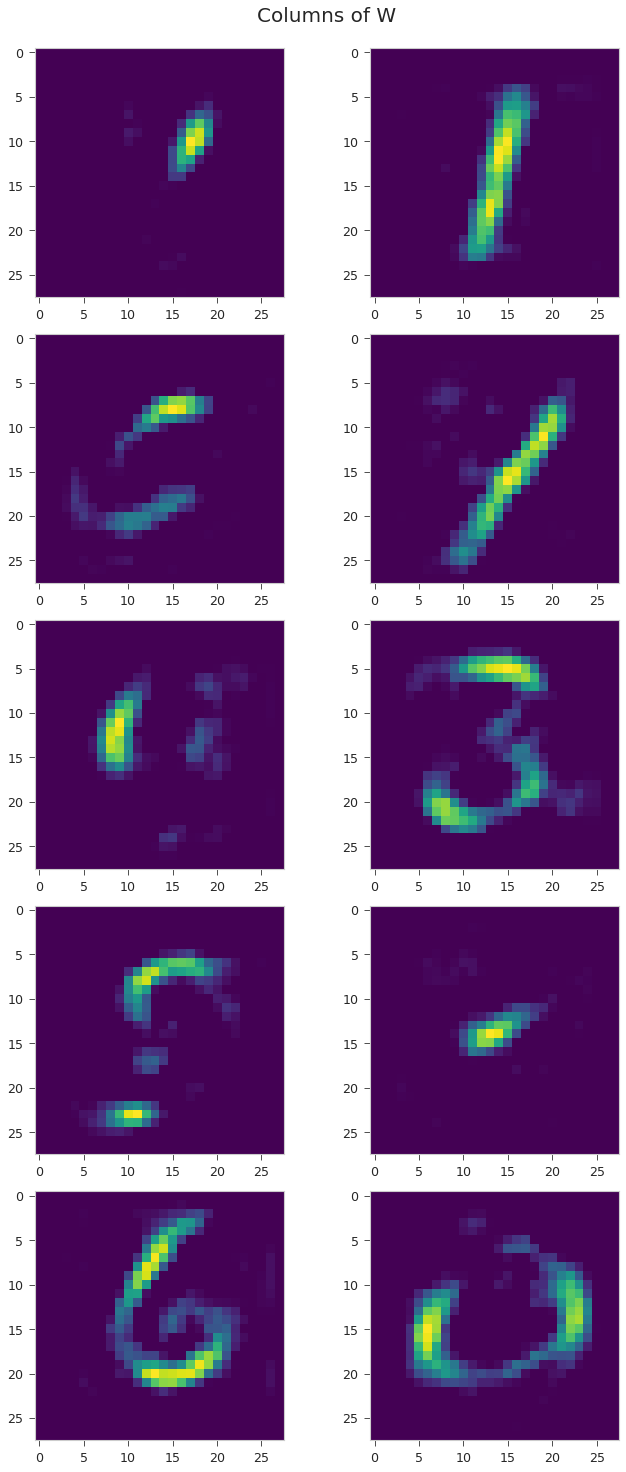

In [18]:
### Regular NMF
from sklearn.decomposition import NMF
model = NMF(n_components=20, init='random', random_state=0)
W = model.fit_transform(imstack_dataset[0])
H = model.components_

show_recons(imstack_dataset[0], W, H)
show_cols(W)